# Classification using distances

In [32]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

## $k$-nearest neighbors

$k$-nearest neighbors is an algorithm for classifying based on a notion of distance.

<font color = 'green'> __Distance/metric__: <font color = black> A function that takes two feature vectors and returns a number measuring distance/dissimilarity between them. Typical properties:

* distances generally nonnegative
* distance between *x* and *x* is zero, often the reverse is true: if *d(x, y) = 0* then *y = x*
* *d(x, y) = d(y, x)*

<font color = 'green'> __Euclidean metric__: <font color = black> The usual measurement of distance between points in space.
    
$$ d(x, y) = \sqrt{\sum_{i=0}^{N-1} (x_i - y_i)^2 } $$

In [33]:
pets = pd.read_csv('pets.csv', index_col=0)
pets

,height,weight,label
pet #,,,
1,21.3,5.1,cat
2,28.8,6.1,cat
3,25.5,4.0,cat
4,27.9,4.8,cat
5,25.1,7.1,cat
6,27.3,5.2,cat
7,28.0,6.8,cat
8,26.2,5.6,cat
9,25.8,4.3,cat


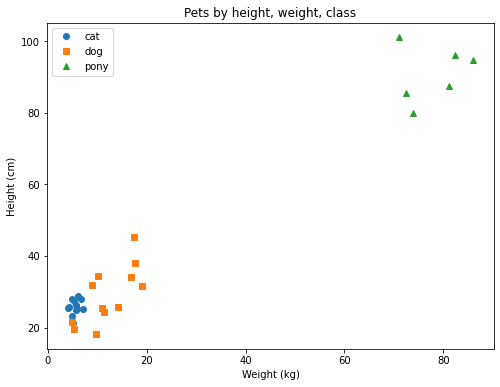

In [34]:
plt.figure(figsize=(8,6))
plt.plot(pets.loc[pets['label'] == 'cat', 'weight'], pets.loc[pets['label'] == 'cat', 'height'], 'o', label = 'cat')
plt.plot(pets.loc[pets['label'] == 'dog', 'weight'], pets.loc[pets['label'] == 'dog', 'height'], 's', label = 'dog')
plt.plot(pets.loc[pets['label'] == 'pony', 'weight'], pets.loc[pets['label'] == 'pony', 'height'], '^', label = 'pony')
plt.title('Pets by height, weight, class')
plt.ylabel('Height (cm)')
plt.xlabel('Weight (kg)')
plt.legend()
plt.show()

In [35]:
new_pets = pd.DataFrame([[31, 30.2, 8.2], [32, 22.2, 5.0], [33, 25.8, 17.8]], columns = ['pet #','height', 'weight'])
new_pets

,pet #,height,weight
0,31,30.2,8.2
1,32,22.2,5.0
2,33,25.8,17.8


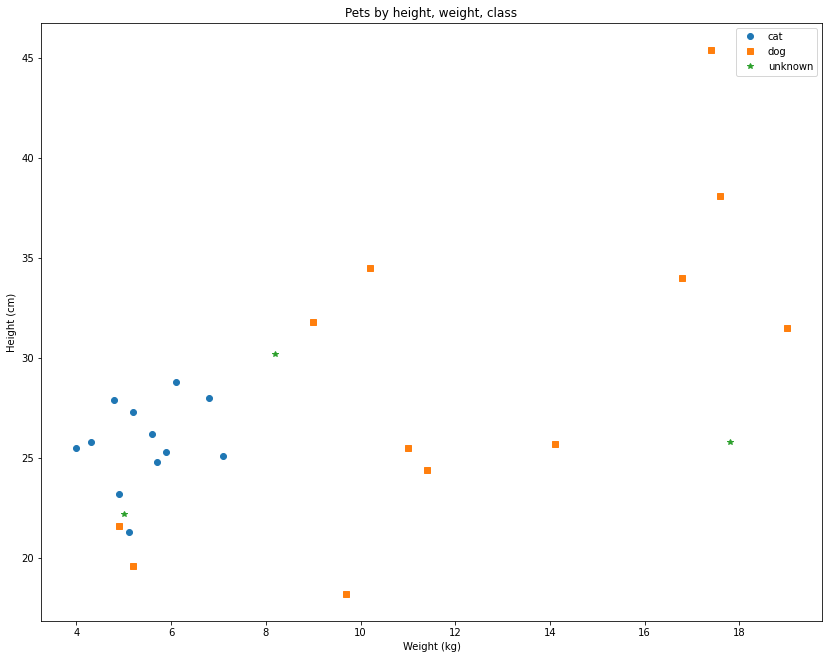

In [36]:
plt.figure(figsize=(14,11))
# Drop ponies from the plot because clearly none of the new pets are ponies
plt.plot(pets.loc[pets['label'] == 'cat', 'weight'], pets.loc[pets['label'] == 'cat', 'height'], 'o', label = 'cat')
plt.plot(pets.loc[pets['label'] == 'dog', 'weight'], pets.loc[pets['label'] == 'dog', 'height'], 's', label = 'dog')
#plt.plot(pets.loc[pets['label'] == 'pony', 'weight'], pets.loc[pets['label'] == 'pony', 'height'], '^', label = 'pony')
plt.plot(new_pets['weight'], new_pets['height'], '*', label = 'unknown')
plt.title('Pets by height, weight, class')
plt.ylabel('Height (cm)')
plt.xlabel('Weight (kg)')
plt.legend()
plt.show()

### Building a simple $k$-nn classifier

#### Step 1: measure distance between points

In [ ]:
def euclidean_distance(v1, v2):
    diff = v1 - v2
    total = np.sum(diff ** 2)
    return np.sqrt(total)

#### Step 2: measure distances from a new point

In [38]:
def get_distance_series(df, new_vec, features):
    '''
    Computes the distance between a new feature vector and each instance in a data frame, using a specified list of features.
    '''
    dlist = []
    for i in df.index:
        dlist.append(euclidean_distance(df.loc[i, features], new_vec[features]))
    return pd.Series(dlist, index = df.index)

In [39]:
get_distance_series(pets, new_pets.loc[2], ['height', 'weight'])

pet #
1     13.473678
2     12.078493
3     13.803260
4     13.168523
5     10.722873
6     12.688972
7     11.217843
8     12.206556
9     13.500000
10    11.910500
11    13.159407
12    12.141252
13    14.042792
14    11.552056
15     5.824946
16     8.260751
17     6.551336
18     3.701351
19    12.301626
20    19.604081
21    13.566503
22     6.806614
23    10.650822
24    11.107205
25    97.015978
26    80.896539
27    88.397511
28    92.173369
29    77.935999
30    95.479893
dtype: float64

<font color = 'green'> __Nearest neighbors:__ <font color = black> the nearest neighbors to a feature vector are the other instances in the data set that are closest to the given feature vector (under whatever notion of distance we're using).

<font color = 'green'> __$k$-nearest neighbors algorithm:__ <font color = black> To classify a new observation (predict its label value), look at the $k$ closest instances in your labeled data set. Take the most common label among those $k$ instances and use that as your prediction.

<font color = green> **Sorting key:** <font color = black> A function that you pass to a sorting function to tell it how to compare two objects.

In [40]:
my_list = [-3, 1, 10, -17, 2, 0, 6, -5, 12, -13]
sorted(my_list, key = np.abs)

[0, 1, 2, -3, -5, 6, 10, 12, -13, -17]

#### Step 3: Sort the training data by distance from the new point

In [41]:
def get_nearest_neighbors(df, new_vec, features, k):
    '''
    Finds the k nearest instances to a new feature vector in the data frame, using a specified list of features.
    '''
    dseries = get_distance_series(df, new_vec, features)
    indices = sorted(df.index, key = lambda i:dseries[i])[:k]
    return df.loc[indices]

In [42]:
get_nearest_neighbors(pets, new_pets.loc[1], ['height', 'weight'], 7)

,height,weight,label
pet #,,,
21,21.6,4.9,dog
1,21.3,5.1,cat
11,23.2,4.9,cat
13,19.6,5.2,dog
12,24.8,5.7,cat
10,25.3,5.9,cat
3,25.5,4.0,cat


In [43]:
instance = new_pets.loc[1]
features = ['weight', 'height']
instance.loc[features]

weight     5.0
height    22.2
Name: 1, dtype: float64

In [44]:
get_nearest_neighbors(pets, new_pets.loc[1], features, 1)

,height,weight,label
pet #,,,
21,21.6,4.9,dog


#### Step 4: Take a vote of the $k$ nearest neighbors

In [ ]:
def majority_vote(nearest_neighbors):
    '''
    Returns the most common label among a set of instances.
    '''
    label = sorted(nearest_neighbors['label'], key = lambda x: sum(nearest_neighbors['label'] == x), reverse = True)[0]
    return label

In [45]:
nn = get_nearest_neighbors(pets, new_pets.loc[0], features, 3)
majority_vote(nn)

'cat'

### Decision boundaries and the geometry of the classifier

<font color = 'green'> **Decision region:** <font color = 'black'> Classifiers partition the feature space into "regions" that get assigned to different classes. A new point can be classified by noting which region it falls into.
    
<font color = 'green'> **Decision boundary:** <font color = 'black'> The boundary between two decision regions -- the shape of the boundary is determined by the training data and the properties of the classifier.

In [46]:
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
X = pets.drop('label', axis = 1)
y = pets['label']
X = X.loc[1:24]
y = y.loc[1:24]
classes = {'cat':0, 'dog':1, 'pony':2}
def make_plot(k, h):
    clf = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean')
    clf.fit(X, y)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X.values[:, 0].min() - 1, X.values[:, 0].max() + 1
    y_min, y_max = X.values[:, 1].min() - 1, X.values[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.array([classes[z] for z in clf.predict(np.c_[xx.ravel(), yy.ravel()])])

    # Put the result into a color plot
    Z = Z.reshape(yy.shape)
    plt.figure(figsize=(12,8))
    plt.pcolormesh(yy, xx, Z, cmap=cmap_light, shading='auto')
    plt.plot(pets.loc[pets['label'] == 'cat', 'weight'], pets.loc[pets['label'] == 'cat', 'height'], 'o', label = 'cat', color = 'black')
    plt.plot(pets.loc[pets['label'] == 'dog', 'weight'], pets.loc[pets['label'] == 'dog', 'height'], 's', label = 'dog', color = 'black')
    #plt.plot(pets.loc[pets['label'] == 'pony', 'weight'], pets.loc[pets['label'] == 'pony', 'height'], '^', label = 'pony', color = 'black')
    plt.legend()
    plt.xlabel('Weight')
    plt.ylabel('Height')
    plt.title(str(k) + '-nearest neighbor classification boundaries')
    plt.show()

#for i in range(1, 8):
#    make_plot(i, 0.3)

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


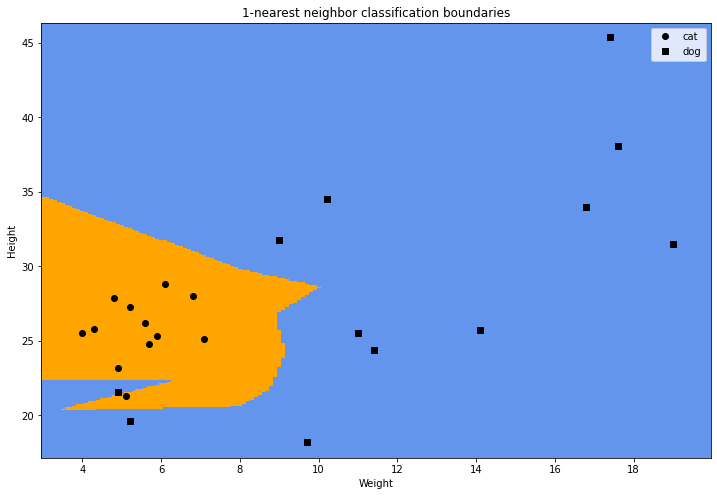

In [47]:
make_plot(1, 0.1)

More distances:

* **Manhattan distance:**
$$ d(x, y) = \sum_{i=0}^{N-1} |x_i - y_i| $$

* **Maximum distance:** 
$$ d(x, y) = \max |x_i - y_i| $$

## Parameter tuning: how to choose $k$

The way to choose $k$ is by using __cross-validation__. Below we do some $k$-fold cross-validation to evaluate $k$-nn classifiers. (Note that these are two different $k$s. Unfortunately, the letter $k$ gets a lot of mileage in this field!)

In [48]:
# Data from a survey of Japanese forests
# Classes: 's': Sugi
#          'h': Hinoki
#          'd': mixed deciduous
#          'o': other non-forest land
training = pd.read_csv('training.csv', usecols=range(0,10))
y = training['class']
X = training.drop('class', axis = 1)
training

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,d,39,36,57,91,59,101,93,27,60
1,h,84,30,57,112,51,98,92,26,62
2,s,53,25,49,99,51,93,84,26,58
3,s,59,26,49,103,47,92,82,25,56
4,d,57,49,66,103,64,106,114,28,59
...,...,...,...,...,...,...,...,...,...,...
193,d,55,61,90,75,55,91,84,24,54
194,d,66,69,93,90,63,100,99,25,57
195,h,79,30,55,115,51,96,109,25,59
196,h,69,27,53,106,47,90,87,24,55


In [49]:
test = pd.read_csv('testing.csv', usecols = range(0, 10))
test_y = test['class']
test_X = test.drop('class', axis = 1)

In [50]:
clf = KNeighborsClassifier(n_neighbors=4)
clf.fit(X,y)

KNeighborsClassifier(n_neighbors=4)

In [51]:
pred = clf.predict(test_X)
confusion_matrix(test_y, pred)

array([[ 85,   2,   5,  13],
       [  0,  33,   0,   5],
       [ 13,   0,  31,   2],
       [  1,  16,   0, 119]])

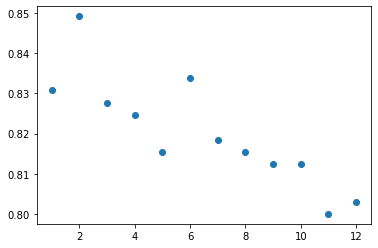

In [52]:
# Try different values of k, 1 through 12
acc = []
for k in range(1, 13):
    clfr = KNeighborsClassifier(n_neighbors=k)
    clfr.fit(X, y)
    acc.append(sum(clfr.predict(test_X) == test_y) / len(test_y))
plt.plot(range(1, 13), acc, 'o')

<font color = 'green'> __Cross-validation__: <font color = black> A technique for evaluating model performance. Split the training set into training/evaluation sets in several different ways and rotate through which set is training and which is testing. Evaluate the accuracy each time, and use the average as an estimate of future model performance.

<font color = 'green'> __$k$-fold cross-validation__: <font color = black> A form of cross-validation where the data is partitioned into $k$ subsets. One subset is held out as the validation set in each rotation, so the model is fitted / evaluated $k$ times.

<font color = green> __Leave-one-out cross-validation__: <font color = black> Same as $k$-fold CV with $k = N$; use a single instance at a time as the held-out validation set. Practical for smaller data sets, slow for larger ones.

In [53]:
# 9-fold cross-validation
folds = np.concatenate([np.repeat(i, len(y) // 9) for i in range(1, 10)])
np.random.shuffle(folds)
folds

array([4, 5, 6, 1, 6, 2, 1, 7, 7, 4, 3, 6, 3, 1, 1, 9, 9, 3, 6, 7, 5, 3,
       9, 2, 8, 7, 9, 1, 6, 7, 3, 1, 5, 4, 2, 8, 6, 8, 1, 5, 3, 9, 1, 7,
       5, 2, 3, 1, 7, 1, 3, 5, 4, 9, 2, 4, 5, 4, 2, 6, 9, 2, 1, 2, 5, 6,
       3, 4, 3, 3, 8, 4, 5, 7, 4, 9, 3, 2, 9, 5, 4, 2, 7, 4, 5, 4, 5, 8,
       4, 8, 6, 3, 6, 5, 1, 6, 8, 2, 4, 3, 4, 5, 7, 7, 4, 9, 7, 2, 9, 1,
       6, 9, 7, 8, 9, 1, 1, 2, 9, 9, 9, 8, 1, 5, 2, 7, 4, 1, 1, 9, 6, 8,
       8, 7, 8, 8, 4, 2, 1, 2, 9, 8, 3, 7, 3, 5, 2, 3, 9, 6, 8, 6, 4, 8,
       7, 2, 4, 1, 5, 5, 8, 3, 5, 1, 7, 6, 6, 7, 4, 7, 8, 8, 2, 3, 9, 6,
       6, 8, 6, 5, 3, 8, 9, 3, 6, 5, 8, 1, 7, 2, 9, 5, 7, 6, 2, 3, 2, 4])

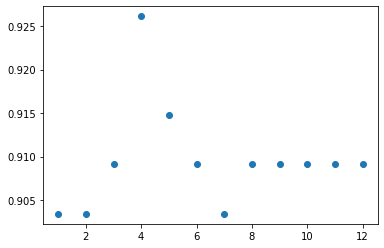

In [55]:
# Try different values of k, 1 through 12
mean_acc = []
for k in range(1, 13):
    acc = []
    for i in range(1, 9):
        clf = KNeighborsClassifier(n_neighbors=k, weights='uniform')
        X0 = training.loc[folds != i].drop('class', axis = 1)
        y0 = training.loc[folds != i]['class']
        X1 = training.loc[folds == i].drop('class', axis = 1)
        y1 = training.loc[folds == i]['class']
        clf.fit(X0, y0)
        acc.append(sum(clf.predict(X1) == y1) / len(y1))
    mean_acc.append(np.average(acc))
plt.plot(range(1, 13), mean_acc, 'o')

#### Example

The code below loads data from various diagnostic tests of breast tissue. Each sample is classified into `car` (carcinoma), `adi` (adipose), `con` (connective), or `fmg` (fibro-adenoma, mastopathy and glandular -- we aren't concerned with distinguishing these three).

In [56]:
tissue = pd.read_csv('tissue1.csv', index_col = 0)
tissue

,Class,I0,PA500,HFS,DA,Area,A/DA,Max IP,DR,P
Case #,,,,,,,,,,
1,car,524.794072,0.187448,0.032114,228.800228,6843.598481,29.910803,60.204880,220.737212,556.828334
2,car,330.000000,0.226893,0.265290,121.154201,3163.239472,26.109202,69.717361,99.084964,400.225776
3,car,551.879287,0.232478,0.063530,264.804935,11888.391827,44.894903,77.793297,253.785300,656.769449
4,car,380.000000,0.240855,0.286234,137.640111,5402.171180,39.248524,88.758446,105.198568,493.701814
5,car,362.831266,0.200713,0.244346,124.912559,3290.462446,26.342127,69.389389,103.866552,424.796503
...,...,...,...,...,...,...,...,...,...,...
102,adi,2000.000000,0.106989,0.105418,520.222649,40087.920984,77.059161,204.090347,478.517223,2088.648870
103,adi,2600.000000,0.200538,0.208043,1063.441427,174480.476218,164.071543,418.687286,977.552367,2664.583623
104,adi,1600.000000,0.071908,-0.066323,436.943603,12655.342135,28.963331,103.732704,432.129749,1475.371534


Below, we use leave-one-out cross-validation to find a good value of $k$ for classifying this data.

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/sarahstueve/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature nam

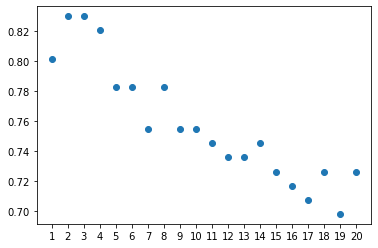

In [57]:
# Try different values of k, 1 through 20
mean_acc = []
for k in range(1, 21):
    acc = []
    for i in tissue.index:
        clf = KNeighborsClassifier(n_neighbors=k, weights='uniform')
        X0 = tissue.drop(i).drop('Class', axis = 1)
        y0 = tissue.drop(i)['Class']
        X1 = tissue.loc[i].drop('Class')
        y1 = tissue.loc[i]['Class']
        clf.fit(X0, y0)
        acc.append(sum(clf.predict(X1.values.reshape(1, -1)) == y1))
    mean_acc.append(np.average(acc))
plt.xticks(range(0, 21, 1))
plt.plot(range(1, 21), mean_acc, 'o')